<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/amazon_fashion/fashion_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot

In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Default GPU Device: /device:GPU:0
True
2.8.0
2.8.0


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## load fashion data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/fashion/02_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/fashion/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/fashion/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/fashion/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(530, 3)
 1.0    386
-1.0     98
 0.0     46
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This China Silk Black Balaclava is great for k...
1,1.0,2004,This item is very lightweight (as you'd expect...
2,1.0,2006,This item came in only 2 days and in perfect c...
3,1.0,2006,This ring was well worth the price. It has a l...
4,1.0,2006,"It was exactly as described. Beautiful ring, ..."


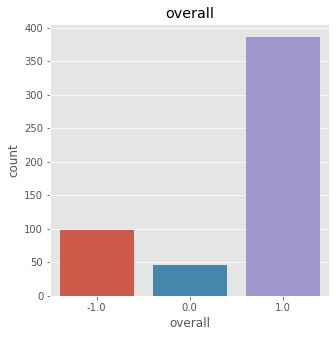

In [ ]:
# load data for 2002 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(16800, 3)
 1.0    12574
-1.0     2657
 0.0     1569
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2012,"I ordered a ladies cigarette case for my wife,..."
1,1.0,2010,Received the case in less than a week...was ve...
2,-1.0,2012,Don't buy this shirt unless you plan to spend ...
3,1.0,2012,"Nice shirt, Well made. good sizing. Nice color..."
4,1.0,2011,If you want a look that takes it back to the O...


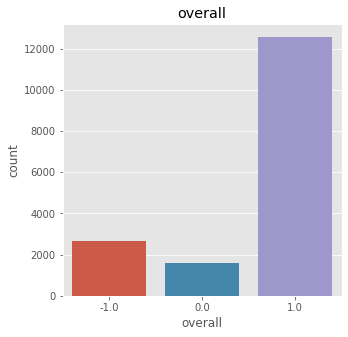

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(614812, 3)
 1.0    413534
-1.0    130175
 0.0     71103
Name: overall, dtype: int64


,overall,reviewTime,reviewText
0,1.0,2014,Exactly what I needed.
1,-1.0,2014,"I agree with the other review, the opening is ..."
2,1.0,2014,Love these... I am going to order another pack...
3,-1.0,2014,too tiny an opening
4,0.0,2014,Okay


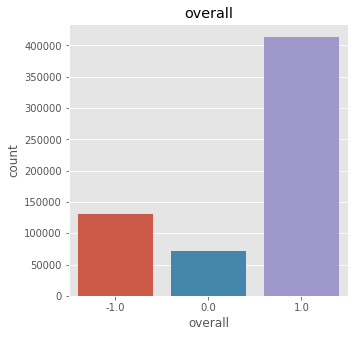

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(47246, 3)
 1.0    33622
-1.0     8865
 0.0     4759
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,Just what I needed for a party
1,1.0,2018,Son loves it. Decent quality.
2,1.0,2018,My son wanted to dress like August Pullman fro...
3,1.0,2018,awesome.
4,1.0,2018,My daughter loves this item. My high score is ...


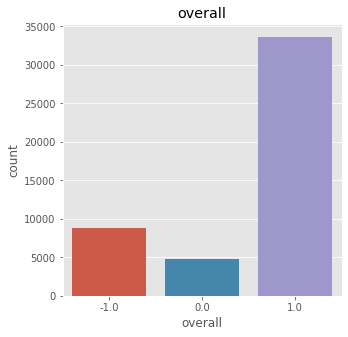

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
6000 positive，2500 negative，1500 neutral except 2002-2006

80%(8000) training and 20%(2000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4800,:]
  train_neudata = neu.iloc[:1200,:]
  train_negdata = neg.iloc[:2000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4800:6000,:]
  test_neudata = neu.iloc[1200:1500,:]
  test_negdata = neg.iloc[2000:2500,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# No data for 2002 - 2006
# df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df1_train,df1_test = split_balance(df2)

# data for 2013 - 2017
df2_train,df2_test = split_balance(df3)

# data for 2018
df3_train,df3_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText
6696,1.0,2010,"I received these yesterday morning, and my lit..."
16559,2.0,2012,I was a little disappointed that I got the wro...
5092,0.0,2012,"At 11 weeks pregnant, I started having difficu..."
11344,1.0,2011,Sexy and practical. I admit I was a skeptic un...
10822,2.0,2012,The small and medium organizers are really too...


## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText,cleanText
6696,1.0,2010,"I received these yesterday morning, and my lit...",received yesterday morning little girl loved m...
16559,2.0,2012,I was a little disappointed that I got the wro...,little disappointed got wrong item purchasing ...
5092,0.0,2012,"At 11 weeks pregnant, I started having difficu...",weeks pregnant started difficulty buttoning pa...
11344,1.0,2011,Sexy and practical. I admit I was a skeptic un...,sexy practical admit skeptic tried soft streng...
10822,2.0,2012,The small and medium organizers are really too...,small medium organizers really small use effec...


In [ ]:
df1_test.head()

,overall,reviewTime,reviewText,cleanText
5543,0.0,2012,The shirt arrived sooner than quoted and looks...,shirt arrived sooner quoted looks completely a...
16297,1.0,2011,just amazing with a high quality design and qu...,amazing high quality design quality quality re...
13771,0.0,2007,These wings are beautiful and looked great too...,wings beautiful looked great jewels made way h...
9503,2.0,2009,Size was no where close to being correct.\nSui...,size close correct suit least sizes smaller ta...
2484,1.0,2012,We buy these by the dozens! My husband is roug...,buy dozens husband rough glasses tends lose li...


## Tokenization

In [ ]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

16069 words are used
Training:
Average length of each row >> 27.203875
Maximum length of each row >> 571


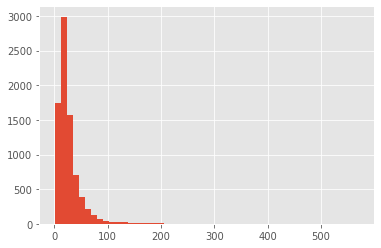

Testing
Average length of each row >> 26.2045
Maximum length of each row >> 242


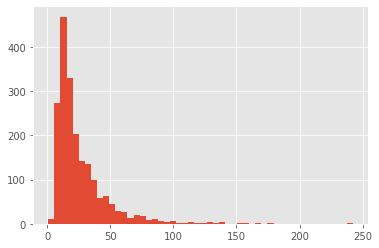

max sequence length:  571


In [ ]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

9772 words are used
Training:
Average length of each row >> 14.769125
Maximum length of each row >> 536


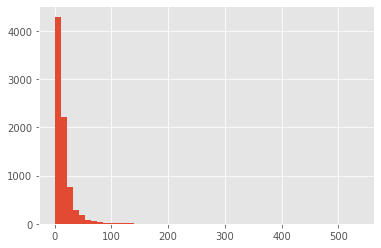

Testing
Average length of each row >> 13.718
Maximum length of each row >> 149


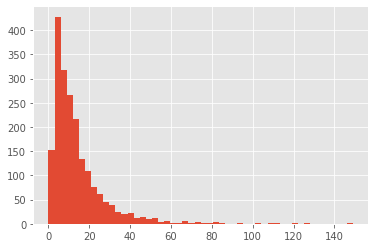

max sequence length:  536


In [ ]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

8884 words are used
Training:
Average length of each row >> 12.30525
Maximum length of each row >> 258


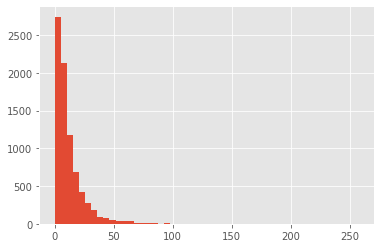

Testing
Average length of each row >> 11.9695
Maximum length of each row >> 199


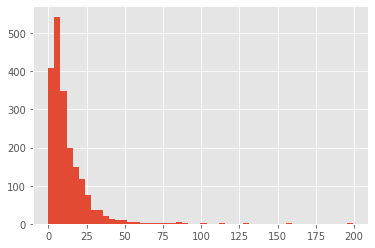

max sequence length:  258


In [ ]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

## Padding

In [ ]:
sequence_size = max(df1_maxlen,df2_maxlen,df3_maxlen)
print("max sequence length for software: ",sequence_size)

max sequence length for software:  571


In [ ]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

In [ ]:
df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

In [ ]:
df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

## Build LSTM Model

In [ ]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 128
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  16069


In [ ]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

### For 2002-2006

In [ ]:
# df1_lstm = bilstm_model()
# plot_model(df1_lstm)
# lstm_no_hist = df1_lstm.fit(df1_train_pad,df1_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_test_pad,df1_test_label),callbacks=[es])

In [ ]:
# plt.plot(lstm_no_hist.history['loss'], label='loss')
# plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
# plt.legend()

In [ ]:
# plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
# plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
# plt.legend()

In [ ]:
# df1_lstm.save('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df1_BiLSTM.h5')

### For 2007-2012

In [ ]:
df1_lstm = bilstm_model()
plot_model(df1_lstm)
lstm_no_hist = df1_lstm.fit(df1_train_pad,df1_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_test_pad,df1_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 571, 100)          1606900   
                                                                 
 bidirectional (Bidirectiona  (None, 571, 256)         234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 146176)            0         
                                                                 
 dense (Dense)               (None, 32)                4677664   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

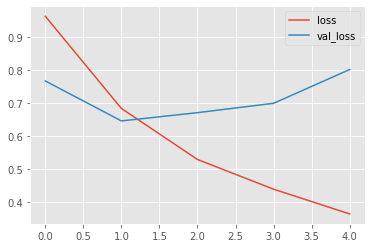

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

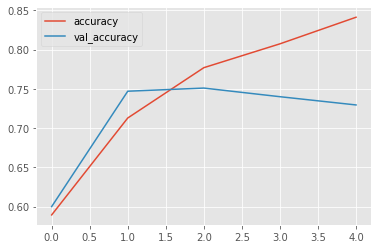

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
df1_lstm.save('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df1_BiLSTM.h5')

### For 2013-2017

In [ ]:
df2_lstm = bilstm_model()
plot_model(df2_lstm)
lstm_no_hist = df2_lstm.fit(df2_train_pad,df2_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df2_test_pad,df2_test_label),callbacks=[es])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 571, 100)          1606900   
                                                                 
 bidirectional_3 (Bidirectio  (None, 571, 256)         234496    
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 146176)            0         
                                                                 
 dense_6 (Dense)             (None, 32)                4677664   
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                      

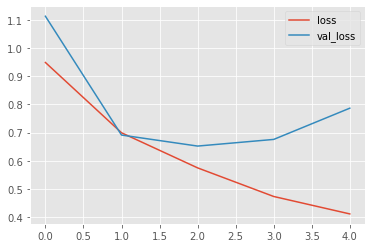

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

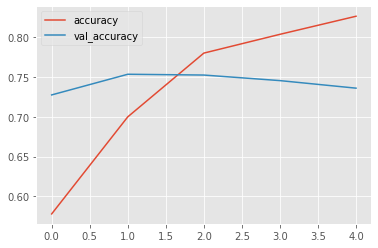

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
df2_lstm.save('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df2_BiLSTM.h5')

### For 2018

In [ ]:
df3_lstm = bilstm_model()
plot_model(df3_lstm)
lstm_no_hist = df3_lstm.fit(df3_train_pad,df3_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df3_test_pad,df3_test_label),callbacks=[es])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 571, 100)          1606900   
                                                                 
 bidirectional_2 (Bidirectio  (None, 571, 256)         234496    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 146176)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                4677664   
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                      

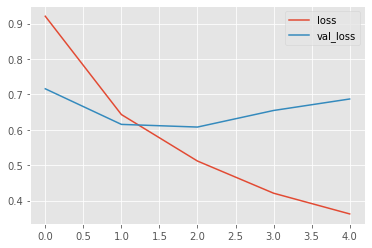

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

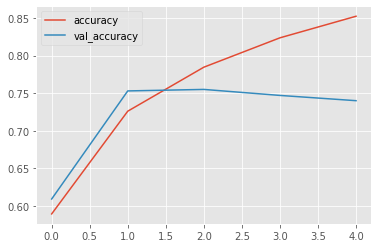

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
df3_lstm.save('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df3_BiLSTM.h5')

## Evaluate on other time data

### For 2002-2006

In [ ]:
# df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df1_BiLSTM.h5')
# df1_model.evaluate(df2_test_pad,df2_test_label)

In [ ]:
# df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df1_BiLSTM.h5')
# df1_model.evaluate(df3_test_pad,df3_test_label)

In [ ]:
# df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df1_BiLSTM.h5')
# df1_model.evaluate(df4_test_pad,df4_test_label)

### For 2007-2012

In [ ]:
df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df1_BiLSTM.h5')
df1_model.evaluate(df2_test_pad,df2_test_label)

63/63 [==============================] - 3s 26ms/step - loss: 1.8103 - accuracy: 0.4135


[1.8102596998214722, 0.41350001096725464]

In [ ]:
df1_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df1_BiLSTM.h5')
df1_model.evaluate(df3_test_pad,df3_test_label)

63/63 [==============================] - 3s 27ms/step - loss: 1.4890 - accuracy: 0.4455


[1.4890493154525757, 0.445499986410141]

### For 2013-2017

In [ ]:
df2_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df2_BiLSTM.h5')
df2_model.evaluate(df1_test_pad,df1_test_label)

63/63 [==============================] - 3s 26ms/step - loss: 2.8885 - accuracy: 0.4560


[2.888536214828491, 0.4560000002384186]

In [ ]:
df2_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df2_BiLSTM.h5')
df2_model.evaluate(df3_test_pad,df3_test_label)

63/63 [==============================] - 3s 26ms/step - loss: 2.1147 - accuracy: 0.4710


[2.114734649658203, 0.47099998593330383]

### For 2018

In [ ]:
df3_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df3_BiLSTM.h5')
df3_model.evaluate(df1_test_pad,df1_test_label)

63/63 [==============================] - 3s 25ms/step - loss: 2.2929 - accuracy: 0.4865


[2.2928781509399414, 0.48649999499320984]

In [ ]:
df3_model = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/df3_BiLSTM.h5')
df3_model.evaluate(df2_test_pad,df2_test_label)

63/63 [==============================] - 3s 27ms/step - loss: 1.8749 - accuracy: 0.4760


[1.874932050704956, 0.47600001096725464]